In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import tensorflow as tf
import keras
from keras.layers import Input
from tensorflow.python.framework import ops
import math
from keras.callbacks import EarlyStopping
from keras import optimizers

## Loading Processed Data

In [ ]:
X_train1 = np.loadtxt('/content/drive/MyDrive/project/data/X_train1.txt', dtype=float)
X_train2 = np.loadtxt('/content/drive/MyDrive/project/data/X_train2.txt', dtype=float)
X_val1 = np.loadtxt('/content/drive/MyDrive/project/data/X_val1.txt', dtype=float)
X_val2 = np.loadtxt('/content/drive/MyDrive/project/data/X_val2.txt', dtype=float)
X_test1 = np.loadtxt('/content/drive/MyDrive/project/data/X_test1.txt', dtype=float)
X_test2 = np.loadtxt('/content/drive/MyDrive/project/data/X_test2.txt', dtype=float)
y_train = np.loadtxt("/content/drive/MyDrive/project/data/y_train.txt", dtype=float)
y_val = np.loadtxt("/content/drive/MyDrive/project/data/y_val.txt", dtype=float)
y_test = np.loadtxt("/content/drive/MyDrive/project/data/y_test.txt", dtype=float)

# Converting Watts to kW
y_train/=1000
y_test/=1000
y_val/=1000

In [ ]:
X_train1.T.shape, y_train[np.newaxis].shape

((168, 22223), (1, 22223))

## Creating the C-RNN Architecture

In [ ]:
X_input = Input([X_train1.shape[1],1])
X_input_2 = Input([X_train2.shape[1],1])

def create_model(X_input, X_input_2):
    
    X1 = keras.layers.Conv1D(kernel_size=(3), filters=64, activation='relu', name='Conv_1')(X_input)
    X1 = keras.layers.MaxPooling1D(pool_size=2, name ='Pool_1')(X1)
    X2 = keras.layers.Conv1D(kernel_size=(5), filters=64, activation='relu', name='Conv_2')(X_input)
    X2 = keras.layers.MaxPooling1D(pool_size=2, name='Pool_2')(X2)
    X3 = keras.layers.Conv1D(kernel_size=(7), filters=64, activation='relu', name='Conv_3')(X_input)
    X3 = keras.layers.MaxPooling1D(pool_size=2, name='Pool_3')(X3)
    X4 = keras.layers.Concatenate(axis=1, name='Concat_1')([X1,X2,X3])
    X5 = keras.layers.LSTM(32, return_sequences=True, name='LSTM_1')(X4)
    X6 = keras.layers.GlobalAveragePooling1D(name='Mean_1')(X5)
    X7 = keras.layers.Flatten()(X_input_2)
    X7 = keras.layers.Dense(32, name='Dense_1')(X7)
    X8 = keras.layers.Concatenate(axis=1, name='Concat_2')([X6,X7])
    X9 = keras.layers.Dense(16, name='Dense_2')(X8)
    Pred = keras.layers.Dense(1, name='Dense_3')(X9)
    
    model = keras.models.Model(inputs=[X_input, X_input_2], outputs=Pred, name='C-RNN')

    return model

In [ ]:
model = create_model(X_input, X_input_2)

In [ ]:
model.summary()

Model: "C-RNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168, 1)]     0                                            
__________________________________________________________________________________________________
Conv_1 (Conv1D)                 (None, 166, 64)      256         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_2 (Conv1D)                 (None, 164, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_3 (Conv1D)                 (None, 162, 64)      512         input_1[0][0]                    
______________________________________________________________________________________________

## Training the Model

In [ ]:
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse', metrics=['acc'])

X_train1 = np.reshape(X_train1,[X_train1.shape[0], X_train1.shape[1],1])
X_train2 = np.reshape(X_train2,[X_train2.shape[0], X_train2.shape[1],1])
X_val1 = np.reshape(X_val1,[X_val1.shape[0], X_val1.shape[1],1])
X_val2 = np.reshape(X_val2,[X_val2.shape[0], X_val2.shape[1],1])

early_stopping_monitor = EarlyStopping(patience=3)
a = model.fit([X_train1, X_train2], y_train, epochs=20, validation_data=([X_val1, X_val2], y_val), callbacks=[early_stopping_monitor])

Epoch 1/20
695/695 [==============================] - 91s 127ms/step - loss: 311.8107 - acc: 0.0000e+00 - val_loss: 25.5720 - val_acc: 0.0000e+00
Epoch 2/20
695/695 [==============================] - 88s 127ms/step - loss: 17.7076 - acc: 0.0000e+00 - val_loss: 8.7976 - val_acc: 0.0000e+00
Epoch 3/20
695/695 [==============================] - 88s 127ms/step - loss: 8.8320 - acc: 0.0000e+00 - val_loss: 9.0246 - val_acc: 0.0000e+00
Epoch 4/20
695/695 [==============================] - 88s 127ms/step - loss: 8.6290 - acc: 0.0000e+00 - val_loss: 8.6124 - val_acc: 0.0000e+00
Epoch 5/20
695/695 [==============================] - 88s 127ms/step - loss: 8.0367 - acc: 0.0000e+00 - val_loss: 8.2844 - val_acc: 0.0000e+00
Epoch 6/20
695/695 [==============================] - 88s 127ms/step - loss: 7.6338 - acc: 0.0000e+00 - val_loss: 7.0497 - val_acc: 0.0000e+00
Epoch 7/20
695/695 [==============================] - 88s 126ms/step - loss: 7.3014 - acc: 0.0000e+00 - val_loss: 7.3092 - val_acc: 0.0000

## Saving the Trained Model

In [ ]:
try:
    from tensorflow.python.keras.models import load_model

    model.save('model.h5')

    
    new_model = load_model('model.h5')
except:
    pass

X_test1 = np.reshape(X_test1,[X_test1.shape[0], X_test1.shape[1],1])
X_test2 = np.reshape(X_test2,[X_test2.shape[0], X_test2.shape[1],1])

## Evaluating Model and Making Predictions

In [ ]:
score_train = model.evaluate([X_train1, X_train2], y_train)
print('MSE_train:', score_train[0])

score_val = model.evaluate([X_val1, X_val2], y_val)
print('MSE_val:', score_val[0])

score_test = model.evaluate([X_test1, X_test2], y_test)
print('MSE_test:', score_test[0])

695/695 [==============================] - 19s 27ms/step - loss: 6.7983 - acc: 0.0000e+00
MSE_train: 6.798252582550049
199/199 [==============================] - 5s 27ms/step - loss: 7.0605 - acc: 0.0000e+00
MSE_val: 7.060455322265625
100/100 [==============================] - 3s 27ms/step - loss: 6.9331 - acc: 0.0000e+00
MSE_test: 6.933051109313965


In [ ]:
pred_test = model.predict([X_test1, X_test2])
pred_train = model.predict([X_train1, X_train2])
pred_val = model.predict([X_val1, X_val2])

## Calculating $R^2$ Value

In [17]:
len(score_test), len(X_test2)

def calc_r_2(pred, y_test):
    mse=0
    for i in range(len(pred)):
        mse+=(pred[i]-y_test[i])**2
    mse/=len(pred)
    # X_test1.shape
    # pred[729], y_test[729]
    mse = mse[0]
    var_y = np.var(y_test)
    return (1-(mse/var_y))

print('train:', calc_r_2(pred_train, y_train))
print('val:', calc_r_2(pred_val, y_val))
print('test:', calc_r_2(pred_test, y_test))

train: 0.8650260565556267
val: 0.8625624714181455
test: 0.8648523655561974


## Plotting the $R^2$ Values

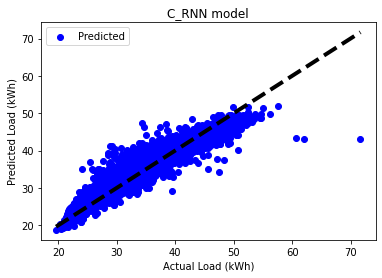

In [18]:
def plot(x,y,x_label=None,y_label=None, title=None, style1=None, color1=None, label1=None, y2=None, label2=None, \
           style2=None, color2=None):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plot1 = plt.scatter(x, y, color=color1)
    plot2, = plt.plot([(y_test).min(), (y_test).max()], [(y_test).min(), (y_test).max()], 'k--', lw=4)
    plt.legend([plot1], [label1, label2])
    plt.show()
    
plot(y_test, pred_test, 'Actual Load (kWh)', 'Predicted Load (kWh)',  'C_RNN model', \
       style1='.', color1='blue', label1='Predicted', y2=y_test, label2='Actual', \
       style2='--', color2='black')
